## Helpers

In [189]:
import pandas as pd
import os
from glob import glob

def load_and_merge_csvs(folder_path, method_name):
    """
    Load and merge all CSV files in a given folder.
    
    Parameters:
        folder_path (str): Path to the folder containing the CSV files.
        method_name (str): Name of the method to tag (e.g. "CoT").
    
    Returns:
        pd.DataFrame: Merged DataFrame with method and run columns.
    """
    # Find all CSV files in the folder
    csv_files = sorted(glob(os.path.join(folder_path, "*.csv")))

    dataframes = []
    for i, file_path in enumerate(csv_files):
        df = pd.read_csv(file_path)
        df["method"] = method_name
        df["run"] = i + 1
        dataframes.append(df)

    # Merge all into one DataFrame
    merged_df = pd.concat(dataframes, ignore_index=True)
    return merged_df

## Load cleaned data

### CoT

In [208]:
cot_all = load_and_merge_csvs("results/cot_few-shot_clean", method_name="CoT")
cot_all.tail()

,id,subject,ground_truth,predicted,correct,method,run
4495,questao_176,Mathematics,D,D,True,CoT,25
4496,questao_177,Mathematics,A,C,False,CoT,25
4497,questao_178,Mathematics,D,D,True,CoT,25
4498,questao_179,Mathematics,C,B,False,CoT,25
4499,questao_180,Mathematics,B,A,False,CoT,25


### CoVe

In [209]:
cove_all = load_and_merge_csvs("results/cove_few-shot_clean", method_name="CoVe")
cove_all.tail()

,id,subject,ground_truth,predicted,correct,initial_answer,method,run
3775,questao_176,Mathematics,D,D,True,D,CoVe,21
3776,questao_177,Mathematics,A,B,False,A,CoVe,21
3777,questao_178,Mathematics,D,D,True,D,CoVe,21
3778,questao_179,Mathematics,C,B,False,B,CoVe,21
3779,questao_180,Mathematics,B,A,False,A,CoVe,21


### Self-Refine

In [210]:
selfrefine_all = load_and_merge_csvs("results/self-refine_few-shot_clean", method_name="Self-Refine")
selfrefine_all.tail()

,id,subject,ground_truth,predicted,correct,initial_answer,method,run
3775,questao_176,Mathematics,D,D,True,D,Self-Refine,21
3776,questao_177,Mathematics,A,D,False,C,Self-Refine,21
3777,questao_178,Mathematics,D,A,False,D,Self-Refine,21
3778,questao_179,Mathematics,C,C,True,E,Self-Refine,21
3779,questao_180,Mathematics,B,A,False,A,Self-Refine,21


### Dataset Summary

In [211]:
print(f"{'Method':<15}{'Rows':<10}{'Columns':<10}{'Runs':<10}{'Unique IDs':<15}")
print("-" * 60)
print(f"{'CoT':<15}{cot_all.shape[0]:<10}{cot_all.shape[1]:<10}{cot_all['run'].nunique():<10}{cot_all['id'].nunique():<15}")
print(f"{'CoVe':<15}{cove_all.shape[0]:<10}{cove_all.shape[1]:<10}{cove_all['run'].nunique():<10}{cove_all['id'].nunique():<15}")
print(f"{'Self-Refine':<15}{selfrefine_all.shape[0]:<10}{selfrefine_all.shape[1]:<10}{selfrefine_all['run'].nunique():<10}{selfrefine_all['id'].nunique():<15}")


Method         Rows      Columns   Runs      Unique IDs     
------------------------------------------------------------
CoT            4500      7         25        180            
CoVe           3780      8         21        180            
Self-Refine    3780      8         21        180            


## Accuracy per Run: Mean

#### Concat data from each method

In [334]:
accuracy_by_run = pd.concat([cot_all, cove_all, selfrefine_all], ignore_index=True)

#### Calculate mean accuracy per method and test run

In [335]:
run_stats = accuracy_by_run.groupby(["method", "run"])["correct"].mean().reset_index()

print("Per-run Accuracy:")
print(run_stats.pivot(index="run", columns="method", values="correct").round(3))

Per-run Accuracy:
method    CoT   CoVe  Self-Refine
run                              
1       0.672  0.672        0.700
2       0.722  0.683        0.694
3       0.661  0.650        0.678
4       0.706  0.672        0.706
5       0.711  0.728        0.722
6       0.711  0.650        0.683
7       0.694  0.639        0.700
8       0.700  0.667        0.700
9       0.706  0.644        0.683
10      0.706  0.650        0.700
11      0.722  0.689        0.683
12      0.683  0.683        0.700
13      0.694  0.683        0.667
14      0.717  0.661        0.656
15      0.711  0.689        0.672
16      0.678  0.689        0.672
17      0.717  0.667        0.694
18      0.667  0.694        0.667
19      0.700  0.644        0.711
20      0.711  0.706        0.694
21      0.711  0.672        0.694
22      0.728    NaN          NaN
23      0.689    NaN          NaN
24      0.694    NaN          NaN
25      0.728    NaN          NaN


## 📊 General Accuracy: General Mean and Standard Deviation

In [336]:
# Compute the number of unique runs per method from the original data.
runs_count = accuracy_by_run.groupby("method")["run"].nunique().reset_index(name="runs")
print("Runs count per method:")
print(runs_count)

# Group by method, subject, and run to compute the per-run average correctness.
df_grouped = accuracy_by_run.groupby(["method", "subject", "run"])["correct"].mean().reset_index()

# Aggregate across runs (across all subjects) for each method.
df_overall = df_grouped.groupby("method")["correct"].agg(["mean", "std"]).reset_index()
df_overall.rename(columns={"mean": "accuracy_mean_all", "std": "accuracy_std_all"}, inplace=True)

# Merge the runs count into df_overall.
df_overall = df_overall.merge(runs_count, on="method")

print("\nOverall Accuracy with Number of Runs:")
print(df_overall)


Runs count per method:
        method  runs
0          CoT    25
1         CoVe    21
2  Self-Refine    21

Overall Accuracy with Number of Runs:
        method  accuracy_mean_all  accuracy_std_all  runs
0          CoT           0.701556          0.192184    25
1         CoVe           0.673016          0.211117    21
2  Self-Refine           0.689418          0.191038    21


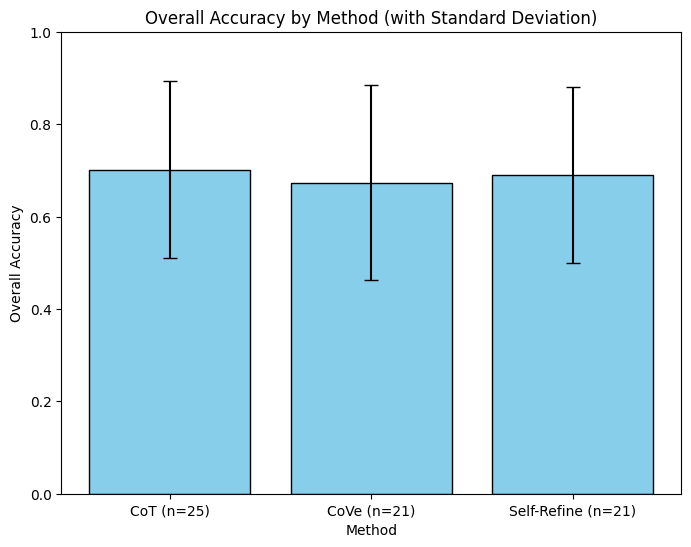

In [337]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
bars = plt.bar(
    df_overall["method"],
    df_overall["accuracy_mean_all"],
    yerr=df_overall["accuracy_std_all"],
    capsize=5,
    color="skyblue",
    edgecolor="black"
)
plt.xlabel("Method")
plt.ylabel("Overall Accuracy")
plt.title("Overall Accuracy by Method (with Standard Deviation)")
plt.ylim(0, 1)  # Adjust if your accuracy scale is 0-1

# Create new x-axis labels that include the run count
new_labels = [f"{m} (n={r})" for m, r in zip(df_overall["method"], df_overall["runs"])]

# Replace the default tick labels with the new labels
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)

plt.show()


## Accuracy per Subject: Mean and Standard Deviation

### Calculate Mean and Standard Deviation

#### Aggregate per Subject

In [341]:
df_agg = (
    accuracy_by_run.groupby(["method", "subject", "run"])["correct"]
    .mean()  # Average correctness per run
    .groupby(["method", "subject"])
    .agg(accuracy_mean="mean", accuracy_std="std")  # Aggregate across runs
    .reset_index()
)

#### Mean

In [217]:
df_accuracy_mean_per_subject = df_agg.pivot(index="method", columns="subject", values="accuracy_mean")

df_accuracy_mean_per_subject

subject,Human Sciences,Languages,Mathematics,Natural Sciences
method,,,,
CoT,0.956444,0.801778,0.486222,0.561778
CoVe,0.940741,0.792593,0.407407,0.551323
Self-Refine,0.947090,0.784127,0.487831,0.538624


#### Standard Deviation

In [218]:
df_accuracy_std_per_subject = df_agg.pivot(index="method", columns="subject", values="accuracy_std")

df_accuracy_std_per_subject

subject,Human Sciences,Languages,Mathematics,Natural Sciences
method,,,,
CoT,0.025240,0.025596,0.053024,0.038233
CoVe,0.028400,0.039959,0.036740,0.036256
Self-Refine,0.021632,0.046157,0.040047,0.039693


#### Mean and Standard Deviation

In [219]:
df_agg["accuracy_formatted"] = df_agg.apply(
    lambda row: f"{row['accuracy_mean']:.3f} ± {row['accuracy_std']:.3f}", axis=1
)

df_accuracy_mean_std_per_subject = df_agg.pivot(index="method", columns="subject", values="accuracy_formatted")

df_accuracy_mean_std_per_subject

subject,Human Sciences,Languages,Mathematics,Natural Sciences
method,,,,
CoT,0.956 ± 0.025,0.802 ± 0.026,0.486 ± 0.053,0.562 ± 0.038
CoVe,0.941 ± 0.028,0.793 ± 0.040,0.407 ± 0.037,0.551 ± 0.036
Self-Refine,0.947 ± 0.022,0.784 ± 0.046,0.488 ± 0.040,0.539 ± 0.040


### 📊 Accuracy per Subject: Mean and Std

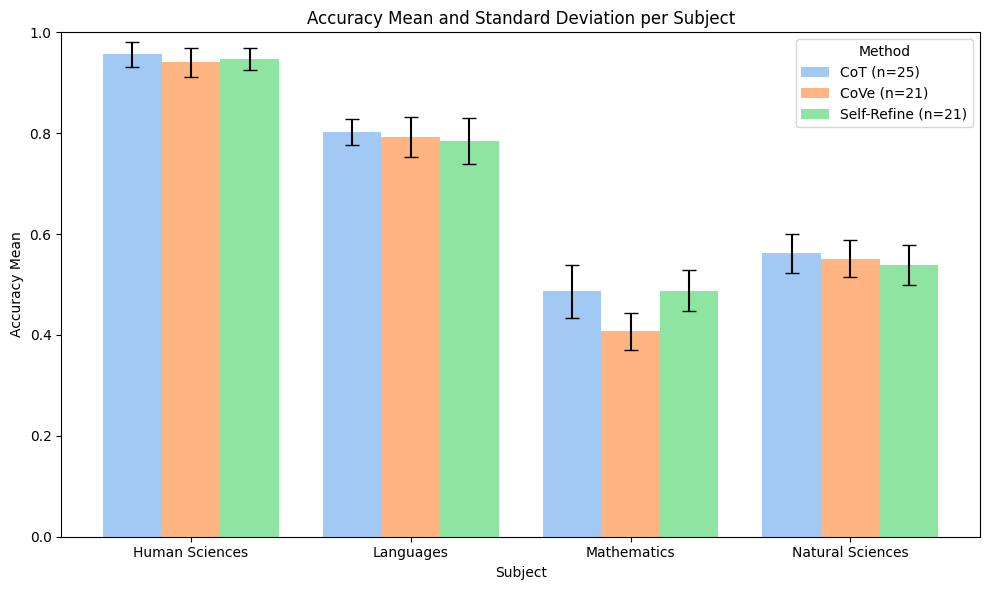

In [318]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # for pastel palette

# Compute the overall number of runs per method
runs_count_overall = accuracy_by_run.groupby("method")["run"].nunique()
runs_dict = runs_count_overall.to_dict()

# Extract subjects and methods
subjects = df_accuracy_mean_per_subject.columns.tolist()
methods = df_accuracy_mean_per_subject.index.tolist()

# Create positions on the x-axis for each subject
n_subjects = len(subjects)
x = np.arange(n_subjects)
bar_width = 0.8 / len(methods)

# Get pastel color palette with as many colors as methods
pastel_colors = sns.color_palette("pastel", n_colors=len(methods))

plt.figure(figsize=(10, 6))

# Plot bars per method with error bars
for i, method in enumerate(methods):
    means = df_accuracy_mean_per_subject.loc[method].values
    stds = df_accuracy_std_per_subject.loc[method].values
    offset = (i - (len(methods) - 1) / 2) * bar_width
    label_with_runs = f"{method} (n={runs_dict.get(method, '?')})"
    
    plt.bar(
        x + offset,
        means,
        bar_width,
        yerr=stds,
        capsize=5,
        label=label_with_runs,
        color=pastel_colors[i]
    )

# Final plot adjustments
plt.xticks(x, subjects)
plt.xlabel("Subject")
plt.ylabel("Accuracy Mean")
plt.title("Accuracy Mean and Standard Deviation per Subject")
plt.ylim(0, 1)
plt.legend(title="Method")
plt.tight_layout()
plt.show()


## Feedback Effects in CoVe and Self-Refine

### Helpers

In [325]:
# --- Consistent color mapping ---
custom_colors = {
    'Improvement': '#B6E2A1',          
    'Regression': '#F7A4A4',           
    'Consistently Correct': '#FFFBC1', 
    'Consistently Incorrect': '#FEBE8C' 
}

# --- Classification function ---
def classify_answer_change(row):
    initial_correct = row['initial_answer'] == row['ground_truth']
    final_correct = row['predicted'] == row['ground_truth']
    if not initial_correct and final_correct:
        return 'Improvement'
    elif initial_correct and not final_correct:
        return 'Regression'
    elif initial_correct and final_correct:
        return 'Consistently Correct'
    else:
        return 'Consistently Incorrect'

# --- Preprocessing function ---
def prepare_data(df, method_label):
    df = df.copy()
    df['result_category'] = df.apply(classify_answer_change, axis=1)
    df['method_label'] = method_label
    return df

# --- Plotting helper for both plots per method ---
def plot_method_row(df, method_label, axs_row):
    # Plot 1: Answer Transitions (Bar Plot)
    counts = df['result_category'].value_counts().reindex([
        'Improvement', 'Regression', 'Consistently Correct', 'Consistently Incorrect'
    ], fill_value=0)
    colors = [custom_colors[cat] for cat in counts.index]
    axs_row[0].bar(counts.index, counts.values, color=colors)
    axs_row[0].set_title(f"Answer Transitions – {method_label}")
    axs_row[0].set_ylabel("Number of Answers")
    axs_row[0].grid(axis='y')
    
    # Remove x-axis tick labels
    axs_row[0].set_xticks([])       # removes the ticks
    axs_row[0].set_xticklabels([])  # removes the labels


    # Plot 2: Stacked Bar per Subject
    subject_counts = (
        df.groupby(['subject', 'result_category'])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=[
            'Improvement', 'Regression', 'Consistently Correct', 'Consistently Incorrect'
        ], fill_value=0)
    )
    subject_counts.plot(
        kind='bar',
        stacked=True,
        ax=axs_row[1],
        color=[custom_colors[col] for col in subject_counts.columns],
        legend=False
    )
    axs_row[1].set_title(f"Feedback Result Categories per Subject – {method_label}")
    axs_row[1].set_ylabel("Number of Questions")
    axs_row[1].set_xlabel("Subject")
    axs_row[1].tick_params(axis='x', rotation=0)
    axs_row[1].grid(axis='y')

### Prepare data

In [326]:
cove_runs = cove_all['run'].nunique()
selfrefine_runs = selfrefine_all['run'].nunique()

cove_all_classified = prepare_data(cove_all, f"Chain-of-Verification ({cove_runs} runs)")
selfrefine_all_classified = prepare_data(selfrefine_all, f"SELF-REFINE ({selfrefine_runs} runs)")

### 📊 Feedback Effects by Method

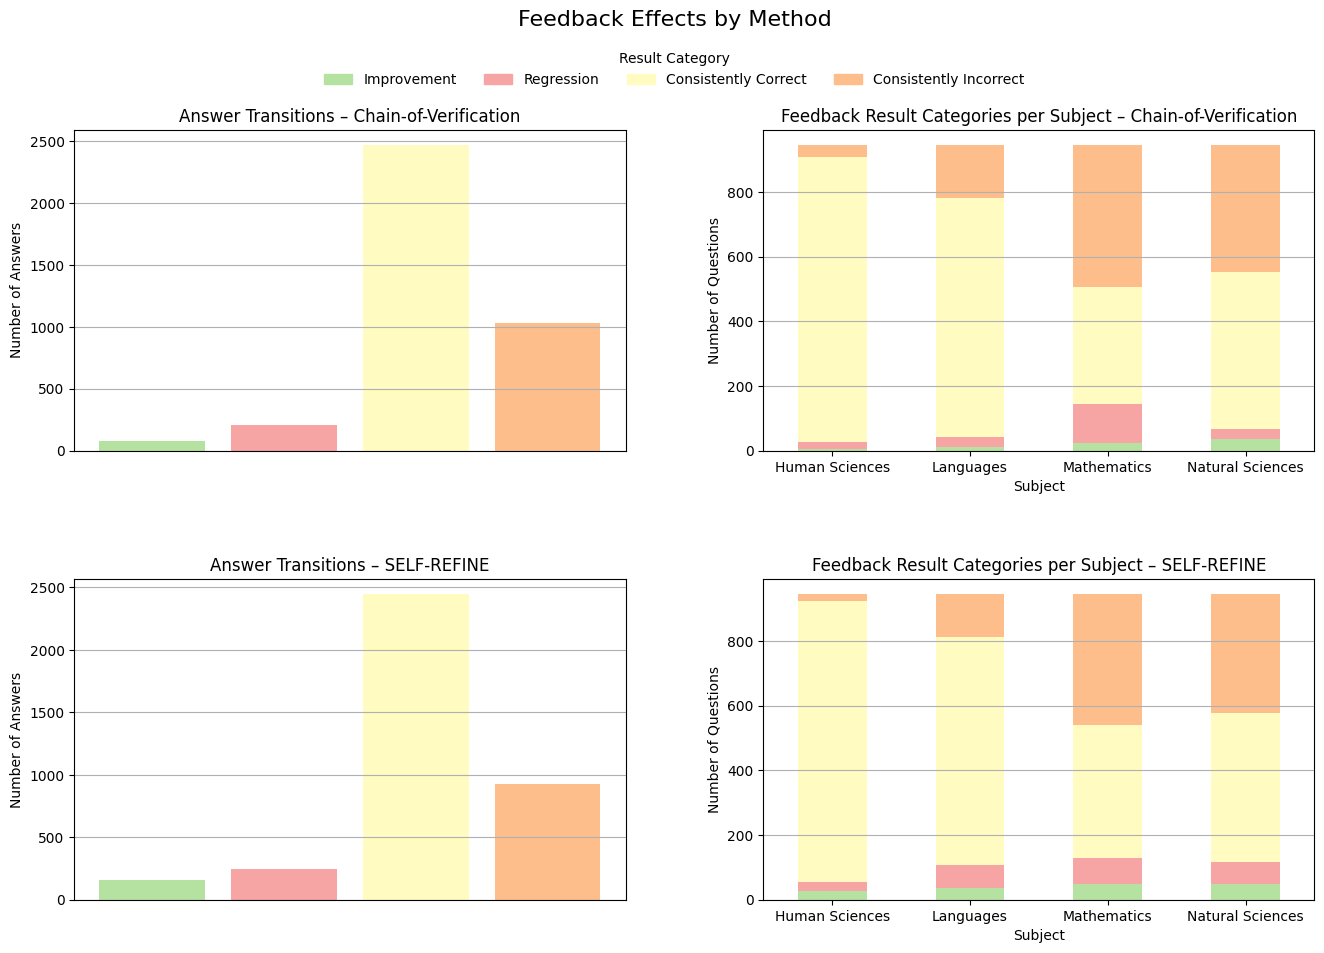

In [327]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create 2x2 plot layout ---
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

plot_method_row(cove_all_classified, "Chain-of-Verification", axs[0])
plot_method_row(selfrefine_all_classified, "SELF-REFINE", axs[1])

# --- Shared legend ---
# Create manual legend to ensure correct colors
from matplotlib.patches import Patch
legend_handles = [
    Patch(color=custom_colors[k], label=k)
    for k in ['Improvement', 'Regression', 'Consistently Correct', 'Consistently Incorrect']
]
fig.legend(
    handles=legend_handles,
    title="Result Category",
    loc='upper center',
    bbox_to_anchor=(0.5, 0.97),
    ncol=4,
    frameon=False
)

fig.suptitle("Feedback Effects by Method", fontsize=16, y=1)
plt.subplots_adjust(top=0.88, hspace=0.4, wspace=0.25)
plt.show()

### 📊 Feedback effects by Subject

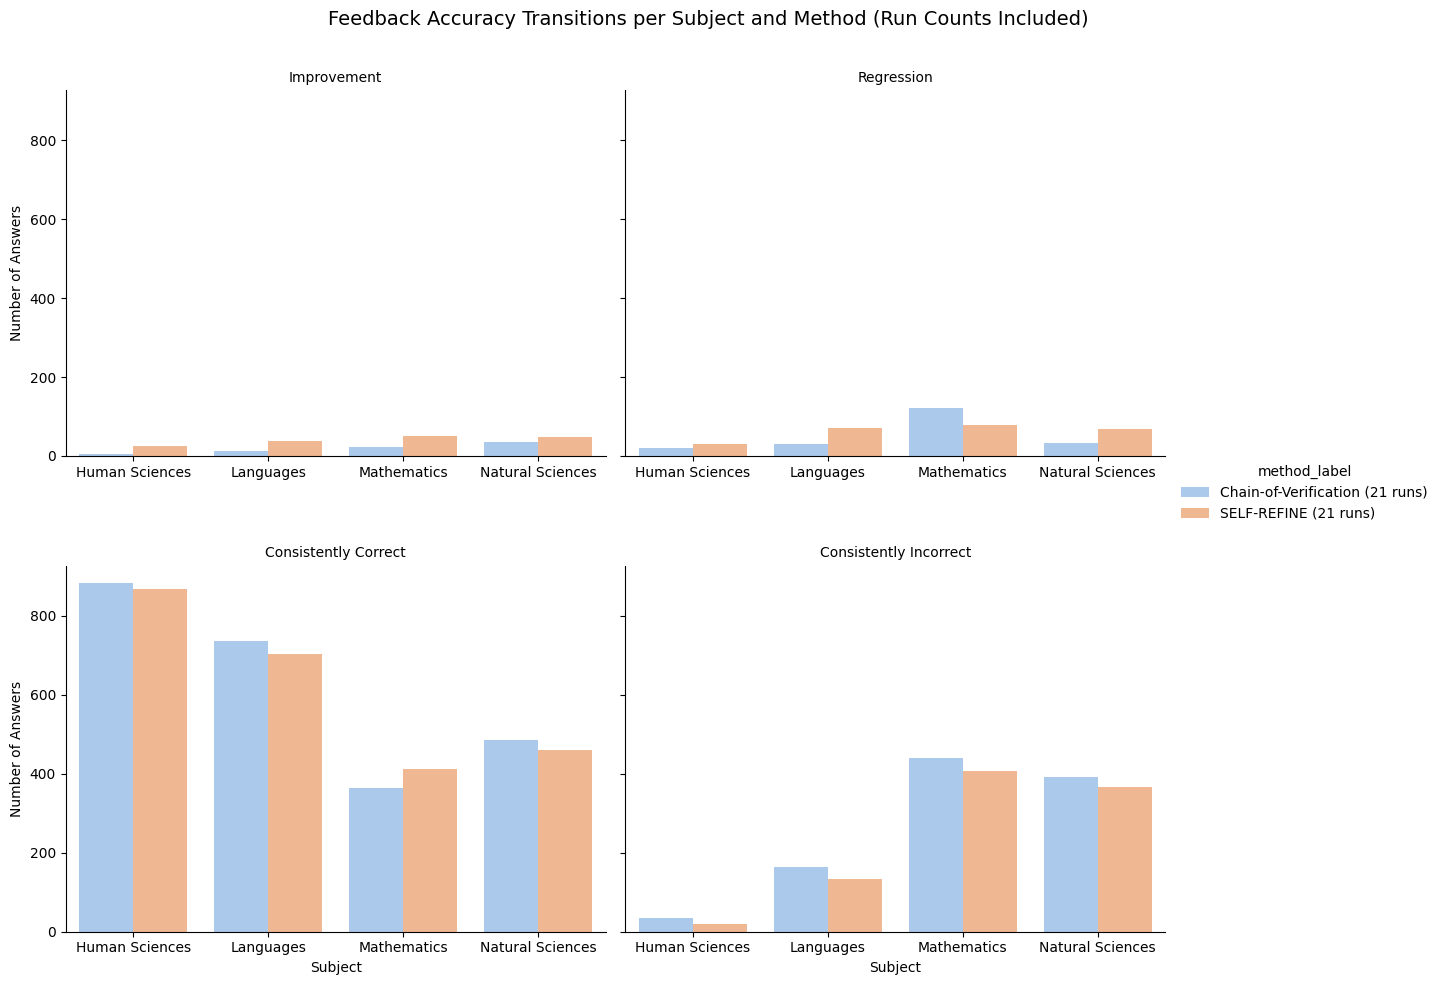

In [328]:
# --- Combine for plotting ---
combined_classified_df = pd.concat([cove_all_classified, selfrefine_all_classified], ignore_index=True)

# --- Grouped counts per subject, method, result category ---
subject_summary = (
    combined_classified_df
    .groupby(['subject', 'method_label', 'result_category'])
    .size()
    .reset_index(name='count')
)

# --- Consistent category order ---
category_order = ['Improvement', 'Regression', 'Consistently Correct', 'Consistently Incorrect']

# --- Plot using Seaborn catplot ---
plot = sns.catplot(
    data=subject_summary,
    x='subject', y='count',
    hue='method_label',
    col='result_category',
    kind='bar',
    col_order=category_order,
    palette='pastel', 
    col_wrap=2,
    height=5, aspect=1.2
)

plot.set_titles("{col_name}")
plot.set_axis_labels("Subject", "Number of Answers")
plot.fig.subplots_adjust(top=0.9, hspace=0.3)
plot.fig.suptitle("Feedback Accuracy Transitions per Subject and Method (Run Counts Included)", fontsize=14)

# Rotate x labels
for ax in plot.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
        label.set_horizontalalignment('center')
    ax.xaxis.set_tick_params(labelbottom=True)

plt.show()

## Statistical Analysis

### Are the differences in average accuracy between CoVe and Self-Refine statistically significant for a given subject?

Null Hypothesis: **There is no difference in the mean accuracy between CoVe and Self-Refine**.

In [352]:
accuracy_per_run_and_subject = (
    accuracy_by_run
    .groupby(['method', 'run', 'subject'])['correct']
    .mean()
    .reset_index(name='accuracy')
)

#### Welch's t-test

Compare the mean accuracy per run between two independent methods (CoVe and Self-Refine) for each subject. These groups may have unequal variances and different numbers of runs. 

Unlike the standard Student’s t-test, Welch’s t-test does not assume equal variances and is more reliable for real-world data where such assumptions may not hold. 

In [349]:
from scipy.stats import ttest_ind
import pandas as pd

# Filter just CoVe and Self-Refine
filtered = accuracy_per_run_and_subject[accuracy_per_run['method'].isin(['CoVe', 'Self-Refine'])]

results = []

for subject in filtered['subject'].unique():
    cove = filtered[(filtered['subject'] == subject) & (filtered['method'] == 'CoVe')]['accuracy']
    refine = filtered[(filtered['subject'] == subject) & (filtered['method'] == 'Self-Refine')]['accuracy']

    stat, p = ttest_ind(cove, refine, equal_var=False)

    results.append({
        'Subject': subject,
        'CoVe Mean': cove.mean(),
        'Self-Refine Mean': refine.mean(),
        'p-value': p,
        'Significant (p < 0.05)': p < 0.05
    })

# Show result summary
results_df = pd.DataFrame(results)
results_df


,Subject,CoVe Mean,Self-Refine Mean,p-value,Significant (p < 0.05)
0,Human Sciences,0.940741,0.947090,4.202436e-01,False
1,Languages,0.792593,0.784127,5.288334e-01,False
2,Mathematics,0.407407,0.487831,3.923047e-08,True
3,Natural Sciences,0.551323,0.538624,2.855903e-01,False


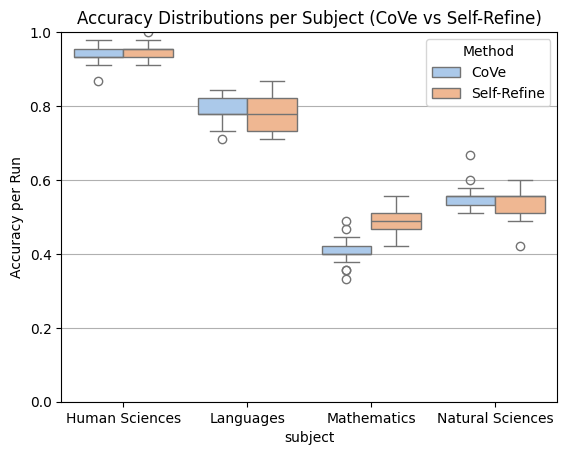

In [350]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=filtered, x='subject', y='accuracy', hue='method', palette='pastel')
plt.title("Accuracy Distributions per Subject (CoVe vs Self-Refine)")
plt.ylabel("Accuracy per Run")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Method')
plt.show()


### Cochran’s Q Test (for Binary Outcomes)

When to Use:
Use this test if your accuracy is binary (e.g., 1 for correct, 0 for incorrect) for each item.

What It Does:
Cochran’s Q test extends the McNemar test to more than two related samples. It tells you whether there is a significant difference in the proportion of correct answers across the three methods.

Follow-Up:
If the test is significant, perform pairwise McNemar tests with appropriate corrections for multiple comparisons.

Analogy:
Imagine you have three different recipes (methods) for the same dish (question). Cochran’s Q test checks if one recipe consistently produces the best dish (accuracy) across repeated trials (items).

In [204]:
import pandas as pd

def create_wide_format(df_cot, df_cove, df_sr):
    """
    Merges the three DataFrames into one 'wide' DataFrame with columns:
      question_id, cot, cove, self_refine
    Each column is a binary indicator (0 or 1) of correctness for that question.
    """
    # Rename "id" to "question_id" if needed
    df_cot = df_cot.rename(columns={"id": "question_id"})
    df_cove = df_cove.rename(columns={"id": "question_id"})
    df_sr = df_sr.rename(columns={"id": "question_id"})

    # Keep only the question_id and correct columns
    df_cot = df_cot[["question_id", "correct"]].copy()
    df_cove = df_cove[["question_id", "correct"]].copy()
    df_sr = df_sr[["question_id", "correct"]].copy()

    # Rename the 'correct' column to indicate which method it belongs to
    df_cot = df_cot.rename(columns={"correct": "cot"})
    df_cove = df_cove.rename(columns={"correct": "cove"})
    df_sr = df_sr.rename(columns={"correct": "self_refine"})

    # Merge the three DataFrames on question_id
    wide_df = df_cot.merge(df_cove, on="question_id").merge(df_sr, on="question_id")

    return wide_df


In [207]:
# Install Pingouin if you haven’t already
# !pip install pingouin

import pingouin as pg

wide_df = create_wide_format(cot_all, cove_all, selfrefine_all)

# Cochran’s Q test requires you to pass each method’s accuracy array separately
Q, pval = pg.cochran(wide_df["cot"], wide_df["cove"], wide_df["self_refine"])

print("Cochran’s Q Test Results:")
print(f"Q statistic = {Q}")
print(f"p-value     = {pval}")


ValueError: Data must be a pandas dataframe or compatible object.

### Repeated-Measures ANOVA (for Continuous/Aggregated Accuracy Scores)

When to Use:
If you can aggregate binary outcomes (e.g., compute the percentage correct per method per test run) or have a continuous accuracy score.

What It Does:
This analysis compares the mean accuracy across the three methods while accounting for the fact that the same items are evaluated by all methods.

Follow-Up:
If the ANOVA shows a significant difference, use post-hoc tests (like Tukey’s HSD) to determine which method pairs differ.

Analogy:
Think of each question as a repeated trial where each method is a different treatment. The repeated-measures ANOVA checks if one treatment leads to a higher average score compared to the others.

### Repeated-Measures Logistic Regression (for Binary Outcomes)

When to Use:
If you want to directly model the binary accuracy outcome while accounting for repeated measures (item-level clustering).

What It Does:
This approach uses a logistic regression framework with random effects for items, comparing the odds of a correct answer among methods.

Follow-Up:
You can examine the fixed effects to see if the method significantly influences the odds of being correct.

Analogy:
Picture each question as a mini-experiment where each method’s chance of "success" (a correct answer) is modeled. The regression tells you if one method has higher odds of success than another.